# 1.项目背景与目标

在社交和内容分享领域，某APP凭借笔记、视频等丰富的内容形式，逐渐吸引了大量用户。作为一个旨在提升用户互动和平台流量的分享平台，推荐算法成为其核心功能，通过精准推送内容，努力实现更高的点击率和转化率，然而，用户群体间的行为差异、内容类型的表现差异、以及推荐效果的优劣，都对平台的整体运营提出了挑战。深入分析这些关键维度，了解用户行为和内容质量，成为优化平台运营和算法策略的重中之重。本次数据分析项目旨在通过对用户行为和内容表现的全面探索，为平台优化提供数据支持。

# 2.数据准备

## 2.1 Python库导入及数据读取

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [11]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体，你也可以尝试其他字体如 'SimHei', 'KaiTi', 'YouYuan' 等
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

In [4]:
data = pd.read_excel("content_analysis_data.xlsx")

## 2.2数据预览

In [5]:
data.head()

,user_id,age_group,gender,device_type,content_id,content_type,topic,length_seconds,content_source,exposures,clicks,liked,favorited,commented,shared,followed_creator,interaction_time
0,U00001,35-44,Male,iOS,C00001,Note,美妆,208,搜索,5,0,0,0,0,0,0,0
1,U00002,18-24,Male,iOS,C00002,Note,时尚,721,搜索,6,0,0,0,0,0,0,0
2,U00003,18-24,Male,Android,C00003,Video,美妆,106,发现页推荐,5,2,0,0,0,0,0,28
3,U00004,18-24,Female,iOS,C00004,Note,家居,461,发现页推荐,10,2,0,0,0,0,0,118
4,U00005,25-34,Female,iOS,C00005,Note,美妆,478,搜索,7,2,0,1,0,1,0,123


In [6]:
print('查看数据信息:')
data.info()

查看数据信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           8000 non-null   object
 1   age_group         8000 non-null   object
 2   gender            8000 non-null   object
 3   device_type       8000 non-null   object
 4   content_id        8000 non-null   object
 5   content_type      8000 non-null   object
 6   topic             8000 non-null   object
 7   length_seconds    8000 non-null   int64 
 8   content_source    8000 non-null   object
 9   exposures         8000 non-null   int64 
 10  clicks            8000 non-null   int64 
 11  liked             8000 non-null   int64 
 12  favorited         8000 non-null   int64 
 13  commented         8000 non-null   int64 
 14  shared            8000 non-null   int64 
 15  followed_creator  8000 non-null   int64 
 16  interaction_time  8000 non-null   int64 
dtypes: int

In [7]:
print(f'查看重复值:{data.duplicated().sum()}')

查看重复值:0


数据总共有 8000 行和 17 列，数据没有缺失值和重复值。

In [8]:
characteristic = data.select_dtypes(include=['object']).columns
print('数据中分类变量的唯一值情况：')
for i in characteristic:
    print(f'{i}:')
    print(f'共有:{len(data[i].unique())}条唯一值')
    print(data[i].unique())
    print('-'*50)

数据中分类变量的唯一值情况：
user_id:
共有:8000条唯一值
['U00001' 'U00002' 'U00003' ... 'U07998' 'U07999' 'U08000']
--------------------------------------------------
age_group:
共有:4条唯一值
['35-44' '18-24' '25-34' '45+']
--------------------------------------------------
gender:
共有:2条唯一值
['Male' 'Female']
--------------------------------------------------
device_type:
共有:2条唯一值
['iOS' 'Android']
--------------------------------------------------
content_id:
共有:8000条唯一值
['C00001' 'C00002' 'C00003' ... 'C07998' 'C07999' 'C08000']
--------------------------------------------------
content_type:
共有:2条唯一值
['Note' 'Video']
--------------------------------------------------
topic:
共有:8条唯一值
['美妆' '时尚' '家居' '美食' '旅游' '健身' '科技' '教育']
--------------------------------------------------
content_source:
共有:3条唯一值
['搜索' '发现页推荐' '关注']
--------------------------------------------------


接下来，要检查数据是否符合逻辑：  
1. clicks=0时，其他互动行为应为0，因为如果用户没有点击内容（clicks=0），那么用户不可能对内容产生互动行为（如点赞、收藏、评论、分享、关注）或观看内容（interaction_time=0）。因此需要检查是否存在clicks=0但liked、favorited、commented、shared、followed_creator或interaction_time不为0的记录。  
2. interaction_time应小于等于length_seconds，因为用户与内容的互动时间（interaction_time）不应超过内容的总时长（length_seconds）。因此需要检查是否存在interaction_time > length_seconds的记录。  
3. clicks应小于等于exposures，因为用户对内容的点击次数（clicks）不应超过内容对用户的曝光次数（exposures）。因此需要检查是否存在clicks > exposures的记录。

In [9]:
# 逻辑检查1：clicks=0时，其他互动行为应为0
invalid_clicks = data[(data['clicks'] == 0) & 
                      ((data['liked'] != 0) | 
                       (data['favorited'] != 0) | 
                       (data['commented'] != 0) | 
                       (data['shared'] != 0) | 
                       (data['followed_creator'] != 0) | 
                       (data['interaction_time'] != 0))]
print("clicks=0但其他互动行为不为0的记录数：", len(invalid_clicks))

# 逻辑检查2：interaction_time应小于等于length_seconds
invalid_interaction_time = data[data['interaction_time'] > data['length_seconds']]
print("interaction_time超过length_seconds的记录数：", len(invalid_interaction_time))

# 逻辑检查3：clicks应小于等于exposures
invalid_clicks_exposures = data[data['clicks'] > data['exposures']]
print("clicks超过exposures的记录数：", len(invalid_clicks_exposures))

# 输出不符合逻辑的记录
if len(invalid_clicks) > 0:
    print("不符合逻辑1的记录：")
    print(invalid_clicks)

if len(invalid_interaction_time) > 0:
    print("不符合逻辑2的记录：")
    print(invalid_interaction_time)

if len(invalid_clicks_exposures) > 0:
    print("不符合逻辑3的记录：")
    print(invalid_clicks_exposures)

clicks=0但其他互动行为不为0的记录数： 0
interaction_time超过length_seconds的记录数： 0
clicks超过exposures的记录数： 0


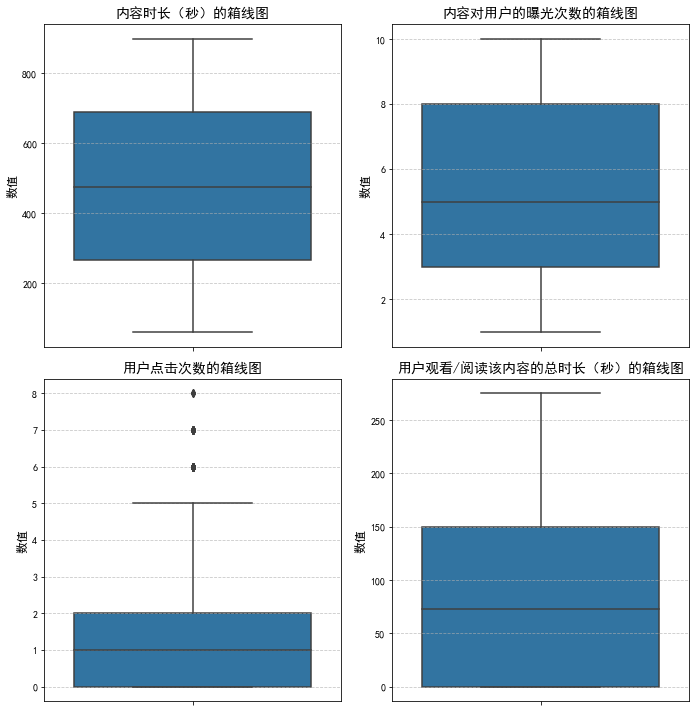

In [12]:
feature_map = {
    'length_seconds': '内容时长（秒）',
    'exposures': '内容对用户的曝光次数',
    'clicks': '用户点击次数',
    'interaction_time': '用户观看/阅读该内容的总时长（秒）'
}
plt.figure(figsize=(10, 10))
for i, (col, col_name) in enumerate(feature_map.items(), 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=data[col])
    plt.title(f'{col_name}的箱线图', fontsize=14)
    plt.ylabel('数值', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 3.探索用户互动行为

## 3.1互动指标构建

In [13]:
data['点赞率'] = data['liked'] / data['exposures']
data['收藏率'] = data['favorited'] / data['exposures']
data['评论率'] = data['commented'] / data['exposures']
data['分享率'] = data['shared'] / data['exposures']
data['关注率'] = data['followed_creator'] / data['exposures']

## 3.2年龄段分组分析

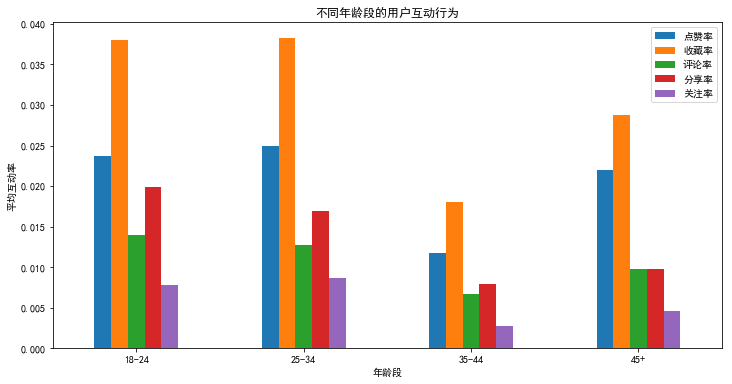

In [14]:
# 按年龄段分组，计算平均互动率
interaction_metrics = ['点赞率', '收藏率', '评论率', '分享率', '关注率']
age_group_interaction = data.groupby('age_group')[interaction_metrics].mean()

age_group_interaction.plot(kind='bar', figsize=(12, 6))
plt.title('不同年龄段的用户互动行为')
plt.xlabel('年龄段')
plt.ylabel('平均互动率')
plt.xticks(rotation=0)
plt.show()

## 单因素方差分析
- 目的：检验 一个分类自变量（factor） 对 一个连续因变量（metric） 的均值是否有显著影响。
- 典型问题：
 - 不同广告投放渠道的转化率均值是否有差异？
 - 不同用户群体的点击率均值是否显著不同？

👉 核心思想：比较“组内差异”和“组间差异”的大小，如果组间差异显著大于组内差异，就认为均值之间有显著差异。

- 组内差异：一个分组内（比如一个班级）的均值（平均分）
- 组间差异：不同分组（不同班级）的均值的差异性
- F统计量：
    - F 值大 → 组间差异 ≫ 组内差异 → 不同组的均值确实不同
    - F 值接近 1 → 组间差异 ≈ 组内差异 → 各组均值差不多
- 显著性指标（p-value）
    - 定义：P 值表示在零假设（H₀：各组均值相等）成立的前提下，观察到当前或更极端结果的概率。
    - 判定标准：
        - 如果 p < 0.05（常用显著性水平 α=0.05），拒绝零假设 → 说明至少有一组均值显著不同。
        - 如果 p >= 0.05，则没有足够证据认为均值不同


In [21]:
## 单因素方差分析（ANOVA）
def anova_method(target_features,interaction_metrics):
    # 初始化结果存储
    anova_results = []

    # 提取目标的互动率数据
    target_groups = data[target_features].unique()

    # 对每个互动指标进行ANOVA检验
    for metric in interaction_metrics:
        ### 返回左右组的
        groups = [data[data[target_features] == target][metric] for target in target_groups]
#         print(*groups)
        f_stat, p_value = f_oneway(*groups)
        anova_results.append({
            '指标': metric,
            'F统计量': round(f_stat, 2),
            'p值': round(p_value, 4),
            '显著性（p<0.05）': '是' if p_value < 0.05 else '否'
        })

    # 转换为DataFrame
    anova_df = pd.DataFrame(anova_results)
    print("ANOVA检验结果：")
    print(anova_df)

In [22]:
anova_method('age_group',interaction_metrics)

ANOVA检验结果：
    指标   F统计量      p值 显著性（p<0.05）
0  点赞率   7.69  0.0000           是
1  收藏率  12.38  0.0000           是
2  评论率   3.79  0.0099           是
3  分享率   7.67  0.0000           是
4  关注率   5.13  0.0015           是


In [13]:
def tukey_method(target_features,interaction_metrics):
    # 初始化结果存储
    tukey_results = []

    # 对每个互动指标进行Tukey HSD检验
    for metric in interaction_metrics:
        tukey = pairwise_tukeyhsd(endog=data[metric], groups=data[target_features], alpha=0.05)
        df_tukey = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
        df_tukey['指标'] = metric  # 添加指标列
        tukey_results.append(df_tukey)

    # 合并所有结果
    tukey_df = pd.concat(tukey_results, ignore_index=True)

    # 筛选显著的结果
    significant_tukey_df = tukey_df[tukey_df['reject'] == True].reset_index(drop=True)

    print("Tukey HSD检验结果（仅显示显著差异）：")
    print(significant_tukey_df)

In [14]:
tukey_method('age_group',interaction_metrics)

Tukey HSD检验结果（仅显示显著差异）：
  group1 group2  meandiff   p-adj   lower   upper  reject   指标
0  18-24  35-44   -0.0120  0.0002 -0.0193 -0.0047    True  点赞率
1  25-34  35-44   -0.0133  0.0000 -0.0206 -0.0059    True  点赞率
2  18-24  35-44   -0.0200  0.0000 -0.0292 -0.0107    True  收藏率
3  25-34  35-44   -0.0203  0.0000 -0.0296 -0.0110    True  收藏率
4  18-24  35-44   -0.0072  0.0066 -0.0128 -0.0015    True  评论率
5  25-34  35-44   -0.0060  0.0328 -0.0117 -0.0003    True  评论率
6  18-24  35-44   -0.0120  0.0000 -0.0188 -0.0051    True  分享率
7  25-34  35-44   -0.0090  0.0044 -0.0159 -0.0021    True  分享率
8  18-24  35-44   -0.0051  0.0085 -0.0092 -0.0010    True  关注率
9  25-34  35-44   -0.0059  0.0012 -0.0101 -0.0018    True  关注率


1. **年轻用户群体（18-24岁、25-34岁）的互动活跃度较高**：  
    
    * 18-24岁和25-34岁群体的**点赞率、收藏率、评论率、分享率和关注率**显著高于35-44岁群体。  
    * **具体差异**：  
        * **点赞率**：18-24岁和25-34岁比35-44岁高 **1.20%** 和 **1.33%**。  
        * **收藏率**：18-24岁和25-34岁比35-44岁高 **2.00%** 和 **2.03%**。  
        * **评论率**：18-24岁和25-34岁比35-44岁高 **0.72%** 和 **0.60%**。  
        * **分享率**：18-24岁和25-34岁比35-44岁高 **1.20%** 和 **0.90%**。  
        * **关注率**：18-24岁和25-34岁比35-44岁高 **0.51%** 和 **0.59%**。  
2. **35-44岁群体的互动行为较低**：  
    
    * 35-44岁群体的互动率在**点赞、收藏、评论、分享、关注**等方面显著低于18-24岁和25-34岁群体。这表明中年群体在平台上的活跃度较低，可能是因为他们对平台内容的兴趣或参与度相对较弱。

## 3.3 性别分组分析

In [15]:
# 按性别分组，计算平均互动率
gender_interaction = data.groupby('gender')[interaction_metrics].mean()

gender_interaction.plot(kind='bar', figsize=(12, 6))
plt.title('不同性别的用户互动行为')
plt.xlabel('性别')
plt.ylabel('平均互动率')
plt.xticks(rotation=0)
plt.show()

<Figure size 1200x600 with 1 Axes>

In [16]:
anova_method('gender',interaction_metrics)

ANOVA检验结果：
    指标   F统计量      p值 显著性（p<0.05）
0  点赞率  29.48  0.0000           是
1  收藏率  21.97  0.0000           是
2  评论率  16.83  0.0000           是
3  分享率  19.67  0.0000           是
4  关注率   8.00  0.0047           是


In [17]:
tukey_method('gender',interaction_metrics)

Tukey HSD检验结果（仅显示显著差异）：
   group1 group2  meandiff   p-adj   lower   upper  reject   指标
0  Female   Male   -0.0112  0.0000 -0.0152 -0.0072    True  点赞率
1  Female   Male   -0.0123  0.0000 -0.0174 -0.0071    True  收藏率
2  Female   Male   -0.0066  0.0000 -0.0097 -0.0034    True  评论率
3  Female   Male   -0.0086  0.0000 -0.0123 -0.0048    True  分享率
4  Female   Male   -0.0033  0.0047 -0.0055 -0.0010    True  关注率


1. **女性用户的互动活跃度显著高于男性用户**：  
    
    * 在**点赞率、收藏率、评论率、分享率和关注率**等互动行为上，**女性用户的活跃度显著高于男性用户**。  
    * 具体来说：  
        * **点赞率**：女性比男性高 **1.12%**。  
        * **收藏率**：女性比男性高 **1.23%**。  
        * **评论率**：女性比男性高 **0.66%**。  
        * **分享率**：女性比男性高 **0.86%**。  
        * **关注率**：女性比男性高 **0.33%**。

## 3.4使用设备分组分析

In [18]:
# 按设备类型分组，计算平均互动率
device_interaction = data.groupby('device_type')[interaction_metrics].mean()

device_interaction.plot(kind='bar', figsize=(12, 6))
plt.title('不同设备类型的用户互动行为')
plt.xlabel('设备类型')
plt.ylabel('平均互动率')
plt.xticks(rotation=0)
plt.show()

<Figure size 1200x600 with 1 Axes>

In [19]:
anova_method('device_type',interaction_metrics)

ANOVA检验结果：
    指标   F统计量   p值 显著性（p<0.05）
0  点赞率  23.35  0.0           是
1  收藏率  44.56  0.0           是
2  评论率  20.42  0.0           是
3  分享率  37.04  0.0           是
4  关注率  32.99  0.0           是


In [20]:
tukey_method('device_type',interaction_metrics)

Tukey HSD检验结果（仅显示显著差异）：
    group1 group2  meandiff  p-adj   lower   upper  reject   指标
0  Android    iOS    0.0094    0.0  0.0056  0.0132    True  点赞率
1  Android    iOS    0.0165    0.0  0.0116  0.0213    True  收藏率
2  Android    iOS    0.0068    0.0  0.0039  0.0098    True  评论率
3  Android    iOS    0.0111    0.0  0.0075  0.0146    True  分享率
4  Android    iOS    0.0063    0.0  0.0041  0.0084    True  关注率


1. **iOS用户的互动行为显著高于Android用户**：  
    
    * 在**点赞率、收藏率、评论率、分享率和关注率**等互动指标上，**iOS用户的活跃度显著高于Android用户**。  
    * **具体差异**：  
        * **点赞率**：iOS比Android高 **0.94%**。  
        * **收藏率**：iOS比Android高 **1.65%**。  
        * **评论率**：iOS比Android高 **0.68%**。  
        * **分享率**：iOS比Android高 **1.11%**。  
        * **关注率**：iOS比Android高 **0.63%**。

# 4.内容质量评估

## 4.1内容质量指标构建

In [21]:
data['完播率'] = data['interaction_time'] / data['length_seconds']
data['点击率'] = data['clicks'] / data['exposures']
data['互动率'] = (data['liked'] + data['favorited'] + data['commented'] + data['shared'] + data['followed_creator']) / data['exposures']

## 4.2不同内容类型表现

In [22]:
# 按内容类型分组，计算平均完播率、点击率和互动率
content_type_quality = data.groupby('content_type', observed=True)[['完播率', '点击率','互动率']].mean()
# 可视化
content_type_quality.plot(kind='bar', figsize=(12, 6))
plt.title('不同内容类型的质量表现')
plt.xlabel('内容类型')
plt.ylabel('平均值')
plt.xticks(rotation=0)
plt.show()

<Figure size 1200x600 with 1 Axes>

In [23]:
anova_method('content_type',['完播率', '点击率','互动率'])

ANOVA检验结果：
    指标   F统计量   p值 显著性（p<0.05）
0  完播率  33.55  0.0           是
1  点击率  90.27  0.0           是
2  互动率  24.38  0.0           是


In [24]:
tukey_method('content_type',['完播率', '点击率','互动率'])

Tukey HSD检验结果（仅显示显著差异）：
  group1 group2  meandiff  p-adj   lower   upper  reject   指标
0   Note  Video    0.0165    0.0  0.0109  0.0221    True  完播率
1   Note  Video    0.0574    0.0  0.0455  0.0692    True  点击率
2   Note  Video    0.0243    0.0  0.0146  0.0339    True  互动率


1. **视频内容的表现优于笔记内容**：  
    
    * 在**完播率、点击率和互动率**方面，**视频（Video）内容显著高于笔记（Note）内容**。  
    * 具体来说，视频内容的完播率、点击率和互动率分别比笔记内容高出一定幅度。  
        * **完播率**：视频内容的完播率比笔记高了1.65%。  
        * **点击率**：视频内容的点击率比笔记高了5.74%。  
        * **互动率**：视频内容的互动率比笔记高了2.43%。

## 4.3不同内容主题表现

In [25]:
# 按内容主题分组，计算平均完播率和互动率
topic_quality = data.groupby('topic', observed=True)[['完播率', '点击率','互动率']].mean()

topic_quality.plot(kind='bar', figsize=(12, 6))
plt.title('不同内容主题的质量表现')
plt.xlabel('内容主题')
plt.ylabel('平均值')
plt.xticks(rotation=0)
plt.show()

<Figure size 1200x600 with 1 Axes>

In [26]:
anova_method('topic',['完播率', '点击率','互动率'])

ANOVA检验结果：
    指标   F统计量   p值 显著性（p<0.05）
0  完播率   7.70  0.0           是
1  点击率  21.28  0.0           是
2  互动率   7.14  0.0           是


In [27]:
tukey_method('topic',['完播率', '点击率','互动率'])

Tukey HSD检验结果（仅显示显著差异）：
   group1 group2  meandiff   p-adj   lower   upper  reject   指标
0      健身     家居   -0.0307  0.0052 -0.0558 -0.0056    True  完播率
1      健身     旅游   -0.0177  0.0009 -0.0307 -0.0047    True  完播率
2      健身     时尚   -0.0205  0.0257 -0.0397 -0.0014    True  完播率
3      家居     美妆    0.0342  0.0008  0.0093  0.0591    True  完播率
4      旅游     美妆    0.0212  0.0000  0.0086  0.0338    True  完播率
5      时尚     美妆    0.0240  0.0029  0.0051  0.0429    True  完播率
6      美妆     美食   -0.0133  0.0105 -0.0248 -0.0018    True  完播率
7      健身     家居   -0.0667  0.0035 -0.1198 -0.0136    True  点击率
8      健身     旅游   -0.0532  0.0000 -0.0806 -0.0259    True  点击率
9      健身     时尚   -0.0762  0.0000 -0.1166 -0.0357    True  点击率
10     健身     科技   -0.0882  0.0042 -0.1593 -0.0171    True  点击率
11     健身     美食   -0.0345  0.0009 -0.0596 -0.0093    True  点击率
12     家居     美妆    0.0888  0.0000  0.0361  0.1414    True  点击率
13     教育     美妆    0.0888  0.0217  0.0072  0.1704    True  点击率
14     旅游     美妆

1. **美妆类内容和健身类全面领跑核心指标**：  
    
    * 在**完播率、点击率和互动率**方面，**美妆、健身内容主题显著比其他内容主题好**。  
    * 具体来说，美妆主题的完播率、点击率和互动率分别比家居、旅游、时尚、美食主题高出一定幅度。  
        * **完播率**：美妆主题的完播率比家居高了3.42%，比旅游的高了2.12%，比时尚的高2.4%，比美食的高1.33%。  
        * **点击率**：美妆主题的点击率比家居高了8.88%，比教育的高了8.88%，比旅游的高7.53%，比时尚的高9.82%，比科技的高11.03%，比美食的高5.65%。  
        * **互动率**：美妆主题的互动率比家居高了5.06%，比教育高了7.06%，比旅游高3.22%，比时尚高3.84%，比美食高2.35%。  
       
    * 健身类主题的完播率、点击率分别比家居、旅游、时尚主题高出一定幅度，但是互动率缺不如美妆类突出。  
        * **完播率**：健身主题的完播率比家居高了3.07%，比旅游的高了1.77%，比时尚的高2.05%。  
        * **点击率**：健身主题的点击率比家居高了6.67%，比旅游的高5.32%，比时尚的高7.62%，比科技的高8.82%，比美食的高3.45%。  
        * **互动率**：健身主题的互动率比家居高了4.46%，比旅游高2.62%。  


2. **家居类内容完播率最低**：  
        
    * 虽然Tukey HSD检验的结果表明家居类与其他类（除美妆类和健身类）不存在显著差异，但通过直方图可以看到，家具类的完播率是最低的，需要考虑如何提高内容质量，或者缩短内容时长，确保提高完播率。  

3. **教育类内容互动率最低**：  
        
    * 教育类在完播率上表现比较好，通过Tukey HSD检验发现教育类的完播率与美妆类和健身类不存在显著差异，但是互动率是最低的，需要想办法提高互动率，需要考虑互动情况，吸引用户互动。  

4. **科技类内容点击率最低**：  
        
    * 科技类与教育类相似，存在某个指标比较低的情况，科技类是点击率较低，可能是因为内容标题不够吸引人，或者只能吸引部分人群导致的，所以在进行推送的时候，科技类可以专门推荐给相关人群，比如最近爆火的Deepseek这一类的可以推送给喜欢看GPT的人群，而不是分享给宝妈、老人等等，因为他们可能不会感兴趣。

# 5.推荐算法效果分析

In [28]:
# 按推荐来源分组，计算平均点击率和互动率
source_performance = data.groupby('content_source')[['点击率', '互动率']].mean()
source_performance.plot(kind='bar', figsize=(12, 6))
plt.title('不同推荐来源的效果')
plt.xlabel('推荐来源')
plt.ylabel('平均值')
plt.xticks(rotation=0)
plt.show()

<Figure size 1200x600 with 1 Axes>

In [29]:
anova_method('content_source',['点击率','互动率'])

ANOVA检验结果：
    指标   F统计量   p值 显著性（p<0.05）
0  点击率  65.37  0.0           是
1  互动率  29.25  0.0           是


In [30]:
tukey_method('content_source',['点击率','互动率'])

Tukey HSD检验结果（仅显示显著差异）：
  group1 group2  meandiff   p-adj   lower   upper  reject   指标
0     关注  发现页推荐   -0.0463  0.0000 -0.0611 -0.0314    True  点击率
1     关注     搜索    0.0324  0.0001  0.0137  0.0512    True  点击率
2  发现页推荐     搜索    0.0787  0.0000  0.0615  0.0960    True  点击率
3     关注  发现页推荐   -0.0237  0.0000 -0.0358 -0.0116    True  互动率
4     关注     搜索    0.0200  0.0060  0.0047  0.0352    True  互动率
5  发现页推荐     搜索    0.0437  0.0000  0.0296  0.0577    True  互动率


1. **搜索得到的内容点击率、互动率是最好的**：  
    
    * 具体来说，搜索得到的内容点击率、互动率分别比关注、发现页推荐得到的内容高出一定幅度。  
        * **点击率**：搜索的点击率比关注高了3.24%，比发现页推荐高了7.87%。  
        * **互动率**：搜索的互动率比关注高了2%，比发现页推荐高了4.37%。  

2. **关注的内容点击率、互动率是第二好的**：  
    
    * 具体来说，关注得到的内容点击率、互动率分别比发现页推荐得到的内容高出一定幅度。  
        * **点击率**：关注的点击率比发现页推荐高了4.63%。  
        * **互动率**：关注的互动率比发现页推荐高了2.37%。

# 6.用户分群分析

In [31]:
features = data[['点赞率', '收藏率', '评论率', '分享率', '关注率']].copy()
scaler = StandardScaler()
x_scaled = scaler.fit_transform(features)

In [32]:
agg_cluster = AgglomerativeClustering(n_clusters=3)
agg_labels = agg_cluster.fit_predict(x_scaled)

# 输出聚类结果
print("层次聚类得到的标签：", np.unique(agg_labels))
print("层次聚类 Silhouette Score:", silhouette_score(x_scaled, agg_labels))

层次聚类得到的标签： [0 1 2]
层次聚类 Silhouette Score: 0.7362942512914383


In [33]:
# 使用 t-SNE 将数据降到二维
tsne = TSNE(n_components=2, random_state=15)
x_tsne = tsne.fit_transform(x_scaled)

# 绘制层次聚类结果
plt.figure(figsize=(8, 6))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=agg_labels, cmap='viridis', s=30)
plt.title("层次聚类结果 (t-SNE 降维后)")
plt.xlabel("t-SNE 组件 1")
plt.ylabel("t-SNE 组件 2")
plt.colorbar(label='聚类标签')
plt.show()

<Figure size 800x600 with 2 Axes>

可以看到，层次聚类效果还是不错的，这里我做一个解释，为啥要使用t-SNE来降维，因为数据之间的线性关系非常弱，如图为皮尔逊相关系数矩阵：  

![Image Name](https://cdn.kesci.com/upload/srbild7pqu.png?imageView2/0/w/960/h/960)  
在非线性的数据中，使用t-SNE能更好地揭示簇的结构。

In [34]:
data['聚类'] = agg_labels
# 计算每个聚类的均值
cluster_means = data.groupby('聚类')[['点赞率', '收藏率', '评论率', '分享率', '关注率']].mean()
# 对每个特征进行归一化处理（每个特征单独归一化）
normalized_means = cluster_means.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# 绘制热力图
plt.figure(figsize=(15, 8))
sns.heatmap(normalized_means.T, 
            cmap='coolwarm',  # 热力图颜色
            center=0.5,  # 中心值
            vmin=0,  # 最小值
            vmax=1,  # 最大值
            annot=cluster_means.T.round(2),  # 显示原始均值（未归一化的均值）
            fmt='.2f',  # 格式化显示的数字
            cbar_kws={'label': '标准化得分'})  # 颜色条标签

plt.xlabel('聚类')
plt.ylabel('特征')
plt.title('各聚类特征分布热力图 (颜色深浅表示在该特征中的相对大小)')
plt.tight_layout()
plt.show()

<Figure size 1500x800 with 2 Axes>

In [35]:
for cluster in range(3):
    cluster_data = data[data['聚类'] == cluster]
    dist = cluster_data['content_source'].value_counts(normalize=True) * 100
    print(f"\nCluster {cluster} ({len(cluster_data)}人):")
    print(dist.round(2))


Cluster 0 (126人):
content_source
关注       38.10
发现页推荐    38.10
搜索       23.81
Name: proportion, dtype: float64

Cluster 1 (7604人):
content_source
发现页推荐    50.43
关注       30.21
搜索       19.36
Name: proportion, dtype: float64

Cluster 2 (270人):
content_source
发现页推荐    40.00
关注       35.56
搜索       24.44
Name: proportion, dtype: float64


* **类0 (126人)**：这类用户的互动情况最好，但他们来自关注和发现页推荐的比例相同（38.10%），而搜索比例较低（23.81%）。这表明这部分用户对于推荐的内容非常积极互动，但并没有转化为关注。需要进一步研究是什么原因导致用户互动后不关注。鉴于这类用户数量较少，建议通过优化推荐算法或增加互动后的关注提示，提高这类用户的关注率，同时尝试将其他用户转化为这类高互动用户。  

* **类1 (7604人)**：这是人数最多的一类，但互动情况最差。发现页推荐占了50.43%，关注占30.21%，搜索占19.36%。这说明推荐算法可能存在问题，需要进行调整。由于无法进一步探索每个用户的喜好，建议从业务角度获取更多用户行为数据，以便构建详细的用户画像，从而进行更有针对性的推荐，提高互动率。  

* **类2 (270人)**：这类用户的互动情况一般，但关注率特别高（关注35.56%，发现页推荐40.00%，搜索24.44%）。这表明这部分用户对推荐内容有一定的忠诚度，但互动不如类0。建议继续保持高关注率，同时通过增加互动性内容或活动来提升他们的互动率。

# 7.用户行为路径分析

In [36]:
# -------------------------------
# 1. 计算整体漏斗数据（曝光、点击、聚合互动）
# -------------------------------
exposures_total = data['exposures'].sum()
clicks_total = data['clicks'].sum()
interaction_total = (data['liked'].sum() + data['favorited'].sum() +
                     data['commented'].sum() + data['shared'].sum() +
                     data['followed_creator'].sum())

# 构建整体漏斗数据
funnel_data = {
    '阶段': ['曝光', '点击', '互动'],
    '数量': [exposures_total, clicks_total, interaction_total]
}
funnel_df = pd.DataFrame(funnel_data)
funnel_df['转化率'] = funnel_df['数量'] / funnel_df['数量'].shift(1)
funnel_df.loc[0, '转化率'] = 1  # 曝光阶段设为100%

# 绘制整体漏斗柱状图
plt.figure(figsize=(10, 6))
sns.barplot(x='阶段', y='数量', data=funnel_df, color='skyblue')
plt.title("用户行为漏斗分析（总体）")
plt.xlabel("行为阶段")
plt.ylabel("数量")
for i, row in funnel_df.iterrows():
    plt.text(i, row['数量'] + max(funnel_df['数量'])*0.01,
             f"转化率: {row['转化率']:.1%}",
             ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 1 Axes>

**整体转化率分析：**  
   - **曝光到点击转化率为 25.7%**，表明约四分之一的用户在看到内容后会点击进入，但仍有较大优化空间，把内容封面和标题设计得更吸引人，比如用热点话题或有趣的图片抓住用户的眼球，同时推送更符合用户兴趣的内容，减少那些用户不感兴趣的内容浪费曝光机会。  
   - **点击到互动转化率为 29.9%**，说明点击后的用户中，近三分之一会参与互动，但互动率仍需提升。

In [37]:
# -------------------------------
# 2. 对点击后的互动行为进行分解分析
# -------------------------------
# 分别计算各互动行为的总数
liked_total = data['liked'].sum()
favorited_total = data['favorited'].sum()
commented_total = data['commented'].sum()
shared_total = data['shared'].sum()
followed_total = data['followed_creator'].sum()

# 构建点击后各互动行为的数据（以点击数为基数计算转化率）
interaction_data = {
    '互动行为': ['点赞', '收藏', '评论', '分享', '关注'],
    '数量': [liked_total, favorited_total, commented_total, shared_total, followed_total]
}
interaction_df = pd.DataFrame(interaction_data)
interaction_df['点击转化率'] = interaction_df['数量'] / data['clicks'].sum()

# 绘制点击后各互动行为转化率的柱状图
plt.figure(figsize=(10, 6))
# 将 '互动行为' 同时作为 x 和 hue，并设置 dodge=False，再关闭图例
ax = sns.barplot(x='互动行为', y='点击转化率', data=interaction_df, hue='互动行为', 
                 palette='viridis', dodge=False)

plt.title("点击后各互动行为转化率")
plt.xlabel("互动行为")
plt.ylabel("转化率")
# 在柱上标注转化率（百分比）和原始数量
for i, row in interaction_df.iterrows():
    plt.text(i, row['点击转化率'],
             f"{row['点击转化率']:.1%}\n({int(row['数量'])})",
             ha='center', va='bottom', fontsize=12)
plt.ylim(0, max(interaction_df['点击转化率']) + 0.1)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 1 Axes>

**点击后互动行为转化率：**  
   - **收藏转化率最高（11.3%）**，表明用户对内容的保存意愿较强，可能因内容对用户具有一定的参考价值，通过提示收藏的功能价值（如便捷访问、存储有价值内容），进一步提高收藏率。  
   - **点赞转化率为 7.4%**，用户有一定的认可意愿，但未达到理想水平，可以添加点赞后的即时反馈（如动态动画或点赞计数展示），提升用户点赞意愿。  
   - **评论转化率为3.9%**，表明用户对深度表达的参与度较低，可以提供评论奖励（如热评展示、积分奖励）或引导用户参与话题讨论，增加评论量。  
   - **分享转化率为 5.0%**，用户传播内容的意愿较低，需要进一步激励，可以添加分享奖励机制（如分享后获得特定权益），并优化分享功能的便捷性，实现跨平台分享。  
   - **关注转化率最低（2.4%）**，说明内容对长期吸引用户关注的效果较弱，可以在用户互动后主动提示关注，如“关注后不错过更多精彩内容”，增强用户关注率。